# Data Engineering & Preprocessing for Customer Churn Analysis

## Objective
This notebook implements a comprehensive data cleaning, preprocessing, and feature engineering pipeline for the customer churn dataset. We will follow best practices in data science to ensure data quality, create interpretable features for explainable AI (XAI), and prepare the dataset for downstream modeling.

## Table of Contents
1. [Environment Setup](#Environment-Setup)
2. [Data Loading](#Data-Loading)
3. [Data Cleaning & Validation](#Data-Cleaning-&-Validation)
    - Missing Values
    - Outlier Detection
    - Data Validation
4. [Feature Engineering](#Feature-Engineering)
    - Binning & Discretization
    - Feature Creation (Ratios & Interactions)
    - Temporal Features
5. [Feature Transformation & Encoding](#Feature-Transformation-&-Encoding)
    - Categorical Encoding
    - Feature Scaling
    - Skewness Correction
6. [Final Dataset Summary](#Final-Dataset-Summary)
7. [Save Processed Dataset](#Save-Processed-Dataset)
8. [Summary](#Summary)

## Environment Setup

We'll load all necessary libraries for data processing, visualization, and modeling. We'll use pandas for data manipulation, sklearn for preprocessing, and numpy for numerical operations.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

# Configure plotting styles
sns.set_style("whitegrid")
px.defaults.template = "plotly_white"

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## Data Loading

Let's load the customer churn dataset and perform initial inspection to understand its structure before applying any preprocessing steps.

In [4]:
# Load the dataset
file_path = '../data/raw/customer_churn_data_original.csv'
df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
print(f"Dataset info:")
print(df.info())
print(f"\nFirst 5 rows:")
df.head()

# Additional data inspection
print(f"\nDataset columns and data types:")
for col in df.columns:
    print(f"{col}: {df[col].dtype} - {df[col].nunique()} unique values")

Dataset shape: (10002, 14)
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB
None

First 5 rows:

Dataset columns and data types:

## Data Cleaning & Validation

In this critical phase, we ensure data quality by addressing missing values, outliers, and data validation issues. Every choice is justified to defend against "garbage in, garbage out". Proper data validation is essential for model robustness and interpretability.

In [5]:
# Initial data inspection
print("Dataset shape before cleaning:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

Dataset shape before cleaning: (10002, 14)

Missing values per column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

Data types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

Basic statistics:
          RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10002.000000  1.000200e+04  10002.000000  10001.000000  10002.000000   
mean    5001.499600  1.569093e+07    650

### Handling Missing Values (Imputation)

First, we must hypothesize why data is missing. The missing data mechanism categorizes into three types:

1. **MCAR (Missing Completely At Random)**: Missingness is independent of both observed and unobserved data.
2. **MAR (Missing At Random)**: Missingness depends on observed data but not on the missing values themselves.
3. **MNAR (Missing Not At Random)**: Missingness depends on the unobserved values themselves.

Understanding the mechanism helps select the appropriate imputation strategy:

- **Simple Methods**: Median (for skewed numerical data like Balance), Mean (for normal data), or Mode (for categorical data).
- **Advanced Methods**: Model-Based Imputation using KNNImputer (assumes similar data points have similar values) or MICE (Multivariate Imputation by Chained Equations).
- **Indicator Columns**: Create binary features (e.g., Was_Age_Missing) to track missingness, which can be a powerful predictor itself.

In [6]:
def detailed_missing_analysis(df):
    """
    Performs a comprehensive analysis of missing values in the dataset.
    
    This function identifies not only standard null values but also
    potential non-standard missing values like empty strings, specific
    placeholder values that might indicate missingness, etc.
    
    For each column with missing values, we'll determine:
    - Type of missingness (MCAR, MAR, MNAR): Understanding the mechanism
    - Appropriate imputation strategy based on data type and missingness pattern
    - Whether to create indicator variables for missingness
    """
    print("=== DETAILED MISSING VALUE ANALYSIS ===")
    
    # Standard missing values
    missing_data = df.isnull().sum()
    missing_percent = 100 * missing_data / len(df)
    missing_table = pd.DataFrame({
        'Column': df.columns, 
        'Missing Count': missing_data, 
        'Percentage': missing_percent
    })
    missing_table = missing_table[missing_table['Missing Count'] > 0].sort_values('Percentage', ascending=False)
    
    print("\nSTANDARD MISSING VALUES (NaN/null):")
    if not missing_table.empty:
        print(missing_table)
    else:
        print("No standard missing values found (NaN/null)")
    
    # Potential non-standard missing values (empty strings, placeholders)
    non_standard_missing = {}
    for col in df.columns:
        # Count empty strings and whitespace-only strings
        if df[col].dtype == 'object':  # Only check for string columns
            empty_str_count = (df[col].astype(str).str.strip() == '').sum()
            if empty_str_count > 0:
                non_standard_missing[col] = empty_str_count
    
    print(f"\nNON-STANDARD MISSING VALUES (empty strings/whitespace):")
    if non_standard_missing:
        for col, count in non_standard_missing.items():
            print(f"  {col}: {count} empty/whitespace values ({count/len(df)*100:.2f}%)")
    else:
        print("No non-standard missing values found")
    
    # Pattern of missingness analysis
    print(f"\nMISSINGNESS PATTERN ANALYSIS:")
    if not missing_table.empty:
        # For columns with missing values, analyze potential patterns
        for col in missing_table['Column']:
            missing_indices = df[df[col].isnull()].index
            # Check if missingness correlates with target variable
            if 'Exited' in df.columns:
                missing_churn_rate = df.iloc[missing_indices]['Exited'].mean()
                overall_churn_rate = df['Exited'].mean()
                print(f"  {col}:")
                print(f"    Missing entries churn rate: {missing_churn_rate:.3f}")
                print(f"    Overall churn rate: {overall_churn_rate:.3f}")
                print(f"    Ratio: {missing_churn_rate/overall_churn_rate:.3f}")
                if abs(missing_churn_rate - overall_churn_rate) > 0.1:
                    print(f"    -> Potentially MNAR (Missing Not At Random)")
                else:
                    print(f"    -> Potentially MCAR or MAR")
    else:
        print("No missing values to analyze for patterns")
    
    return missing_table, non_standard_missing

# Perform detailed missing value analysis
missing_table, non_standard_missing = detailed_missing_analysis(df)

# For categorical columns, also check for suspicious values that might indicate missingness
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
print(f"\nCATGORICAL COLUMN VALUES ANALYSIS:")
for col in categorical_cols:
    print(f"\n{col}:")
    value_counts = df[col].value_counts(dropna=False)
    print(value_counts)

=== DETAILED MISSING VALUE ANALYSIS ===

STANDARD MISSING VALUES (NaN/null):
                        Column  Missing Count  Percentage
Geography            Geography              1    0.009998
Age                        Age              1    0.009998
HasCrCard            HasCrCard              1    0.009998
IsActiveMember  IsActiveMember              1    0.009998

NON-STANDARD MISSING VALUES (empty strings/whitespace):
No non-standard missing values found

MISSINGNESS PATTERN ANALYSIS:
  Geography:
    Missing entries churn rate: 0.000
    Overall churn rate: 0.204
    Ratio: 0.000
    -> Potentially MNAR (Missing Not At Random)
  Age:
    Missing entries churn rate: 0.000
    Overall churn rate: 0.204
    Ratio: 0.000
    -> Potentially MNAR (Missing Not At Random)
  HasCrCard:
    Missing entries churn rate: 0.000
    Overall churn rate: 0.204
    Ratio: 0.000
    -> Potentially MNAR (Missing Not At Random)
  IsActiveMember:
    Missing entries churn rate: 0.000
    Overall churn ra

### Advanced Missing Value Imputation Strategy

Based on our analysis, we'll implement an appropriate imputation strategy. For this dataset, we'll use the following approach:

1. **Simple Imputation**: For categorical variables with clear modes
2. **KNN Imputation**: For numerical variables where similarity to other records is informative
3. **Indicator Variables**: Track which values were originally missing as predictive features

In [7]:
# Advanced missing value handling with multiple strategies

# First, create a copy for processing
df_processed = df.copy()

# Drop irrelevant columns that don't contribute to prediction
df_processed = df_processed.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Create missing value indicators for columns with missing data
missing_cols = ['HasCrCard', 'IsActiveMember', 'Geography', 'Gender']
for col in missing_cols:
    if col in df_processed.columns:
        missing_indicator = df_processed[col].isna().astype(int)
        df_processed[f'{col}_WasMissing'] = missing_indicator
        print(f"Created missing indicator for {col}, {missing_indicator.sum()} records had missing values")

# Impute missing values based on data type and domain knowledge
# For categorical variables, use mode imputation
categorical_features = ['Geography', 'Gender']
for col in categorical_features:
    mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
    df_processed[col] = df_processed[col].fillna(mode_value)
    print(f"Imputed {col} with mode: {mode_value}")

# For binary categorical variables
binary_features = ['HasCrCard', 'IsActiveMember']
for col in binary_features:
    mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 0
    df_processed[col] = df_processed[col].fillna(mode_value)
    print(f"Imputed {col} with mode: {mode_value}")

# Check if there are any remaining missing values
print(f"\nRemaining missing values after imputation:")
print(df_processed.isnull().sum())

print(f"\nDataset shape after missing value handling: {df_processed.shape}")
print(df_processed.head())

Created missing indicator for HasCrCard, 1 records had missing values
Created missing indicator for IsActiveMember, 1 records had missing values
Created missing indicator for Geography, 1 records had missing values
Created missing indicator for Gender, 0 records had missing values
Imputed Geography with mode: France
Imputed Gender with mode: Male
Imputed HasCrCard with mode: 1.0
Imputed IsActiveMember with mode: 1.0

Remaining missing values after imputation:
CreditScore                  0
Geography                    0
Gender                       0
Age                          1
Tenure                       0
Balance                      0
NumOfProducts                0
HasCrCard                    0
IsActiveMember               0
EstimatedSalary              0
Exited                       0
HasCrCard_WasMissing         0
IsActiveMember_WasMissing    0
Geography_WasMissing         0
Gender_WasMissing            0
dtype: int64

Dataset shape after missing value handling: (10002, 15)
 

### Handling Outliers & Anomalies

In customer churn modeling, we must distinguish between anomalies (data entry errors) and rare but valid events:

- **Anomalies (Errors)**: Remove or cap them (e.g., using the IQR 1.5x rule or Z-score > 3)
- **Rare Events (Truth)**: Keep them. Models must learn from these.

We'll use statistical methods (IQR, Z-score) along with domain knowledge to make informed decisions.

In [8]:
# Identify numerical columns for outlier detection
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Function to identify outliers using IQR method
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function to identify outliers using Z-score method
def detect_outliers_zscore(df, col, threshold=3):
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    outliers = df[z_scores > threshold]
    return outliers

# Perform comprehensive outlier analysis
outlier_summary = {}
for col in numerical_cols:
    outliers_iqr, lower, upper = detect_outliers_iqr(df_processed, col)
    outliers_zscore = detect_outliers_zscore(df_processed, col)
    
    print(f"\n{col} Outlier Analysis:")
    print(f"  IQR Method - Outliers: {len(outliers_iqr)} ({len(outliers_iqr)/len(df_processed)*100:.2f}%)")
    print(f"  Z-Score Method - Outliers: {len(outliers_zscore)} ({len(outliers_zscore)/len(df_processed)*100:.2f}%)")
    print(f"  Range (IQR): [{lower:.2f}, {upper:.2f}]")
    print(f"  Actual Min/Max: [{df_processed[col].min():.2f}, {df_processed[col].max():.2f}]")
    
    outlier_summary[col] = {
        'iqr_count': len(outliers_iqr),
        'zscore_count': len(outliers_zscore),
        'iqr_percentage': len(outliers_iqr)/len(df_processed)*100,
        'zscore_percentage': len(outliers_zscore)/len(df_processed)*100
    }


CreditScore Outlier Analysis:
  IQR Method - Outliers: 15 (0.15%)
  Z-Score Method - Outliers: 8 (0.08%)
  Range (IQR): [383.00, 919.00]
  Actual Min/Max: [350.00, 850.00]

Age Outlier Analysis:
  IQR Method - Outliers: 359 (3.59%)
  Z-Score Method - Outliers: 133 (1.33%)
  Range (IQR): [14.00, 62.00]
  Actual Min/Max: [18.00, 92.00]

Tenure Outlier Analysis:
  IQR Method - Outliers: 0 (0.00%)
  Z-Score Method - Outliers: 0 (0.00%)
  Range (IQR): [-3.00, 13.00]
  Actual Min/Max: [0.00, 10.00]

Balance Outlier Analysis:
  IQR Method - Outliers: 0 (0.00%)
  Z-Score Method - Outliers: 0 (0.00%)
  Range (IQR): [-191471.76, 319119.60]
  Actual Min/Max: [0.00, 250898.09]

NumOfProducts Outlier Analysis:
  IQR Method - Outliers: 60 (0.60%)
  Z-Score Method - Outliers: 60 (0.60%)
  Range (IQR): [-0.50, 3.50]
  Actual Min/Max: [1.00, 4.00]

EstimatedSalary Outlier Analysis:
  IQR Method - Outliers: 0 (0.00%)
  Z-Score Method - Outliers: 0 (0.00%)
  Range (IQR): [-96616.10, 296983.51]
  Actual 

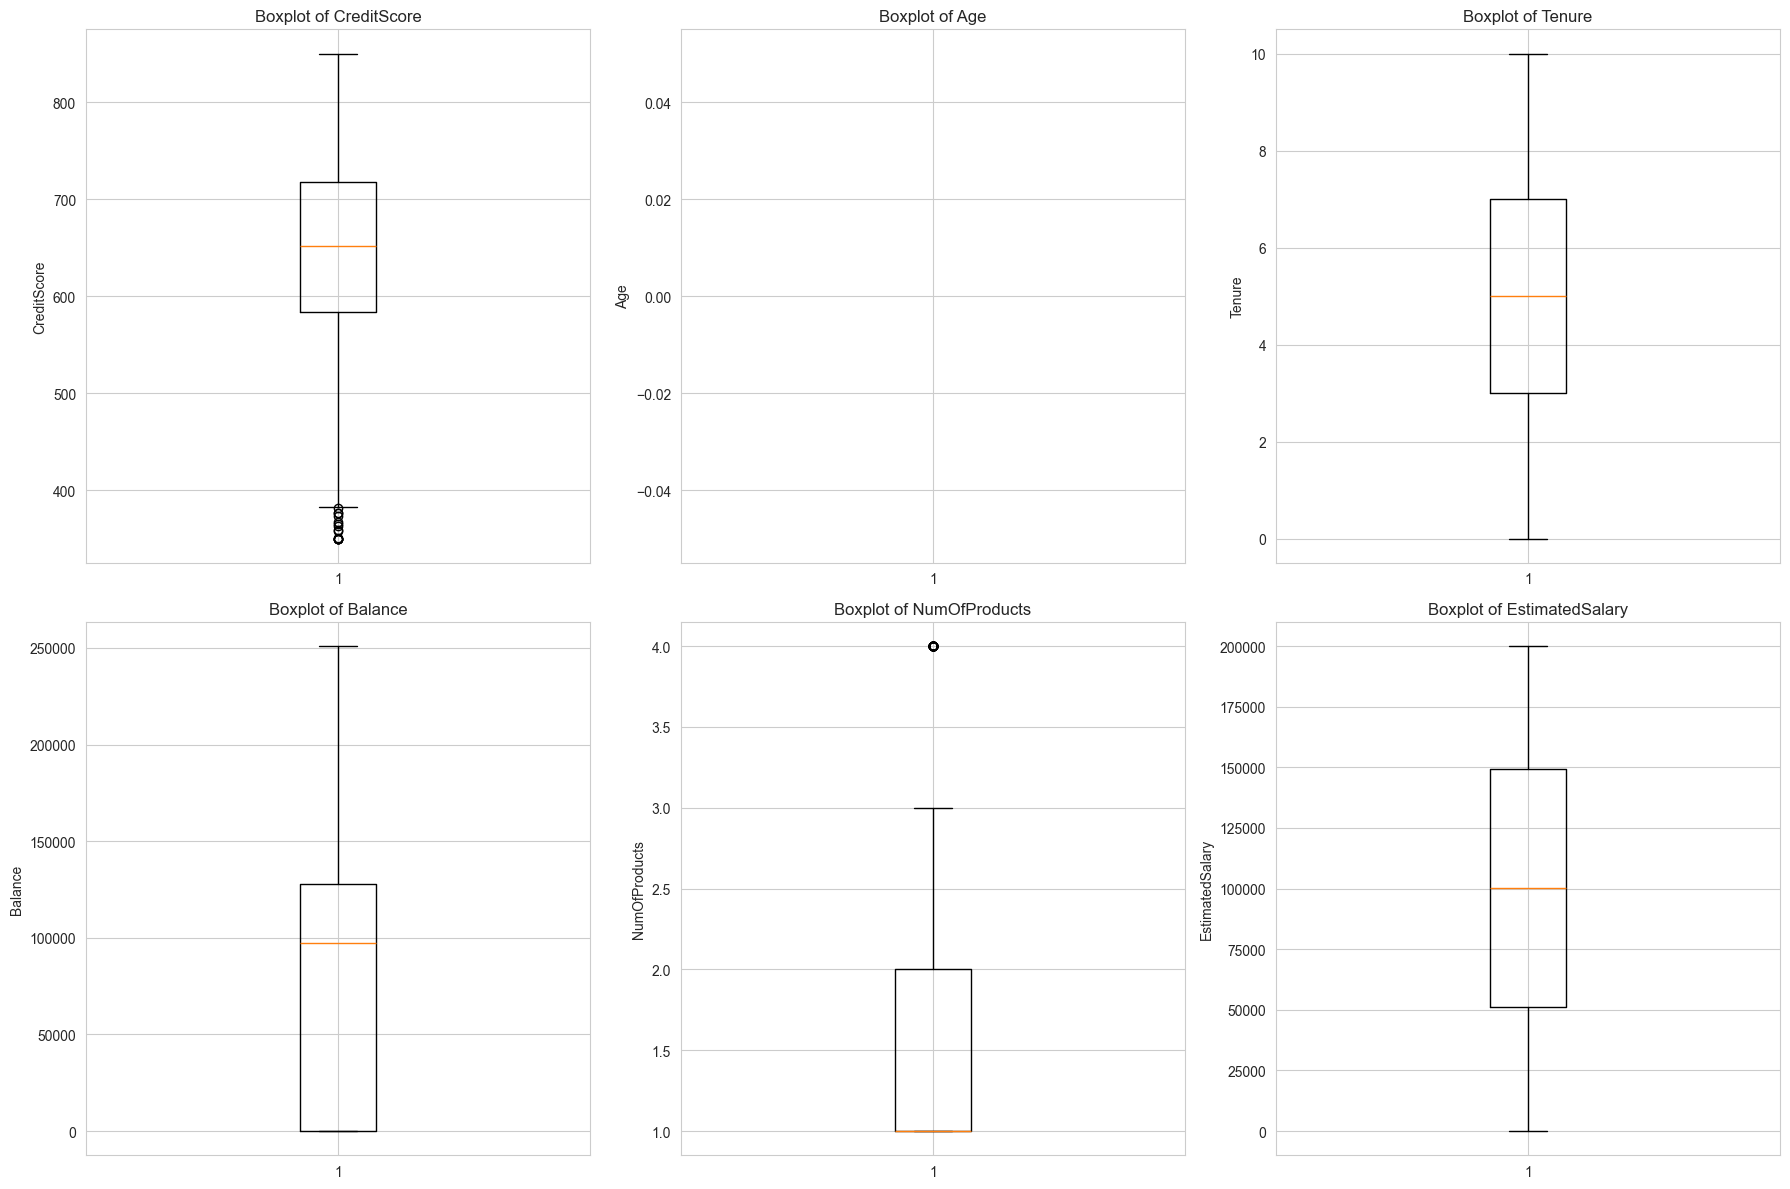


Domain-based outlier assessment:
Impossible ages (18-100): 0 records

Impossible credit scores (300-850): 0 records

High balance customers (>95th percentile): 501 records
Max balance: 250898.09

High salary customers (>95th percentile): 501 records
Max salary: 199992.48


In [9]:
# Visualize outlier distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df_processed[col])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

# For each variable, determine if outliers are anomalies or valid rare events
print("\nDomain-based outlier assessment:")

# Age outliers
impossible_ages = df_processed[(df_processed['Age'] < 18) | (df_processed['Age'] > 100)]
print(f"Impossible ages (18-100): {len(impossible_ages)} records")
if len(impossible_ages) > 0:
    print(impossible_ages[['Age', 'Exited']].head(10))

# Credit Score outliers
impossible_credit = df_processed[(df_processed['CreditScore'] < 300) | (df_processed['CreditScore'] > 850)]
print(f"\nImpossible credit scores (300-850): {len(impossible_credit)} records")
if len(impossible_credit) > 0:
    print(impossible_credit[['CreditScore', 'Exited']].head(10))

# Balance outliers (these are often valid - wealthy customers can have high balances)
high_balance = df_processed[df_processed['Balance'] > df_processed['Balance'].quantile(0.95)]
print(f"\nHigh balance customers (>95th percentile): {len(high_balance)} records")
print(f"Max balance: {df_processed['Balance'].max()}")

# Estimated salary outliers (also often valid)
high_salary = df_processed[df_processed['EstimatedSalary'] > df_processed['EstimatedSalary'].quantile(0.95)]
print(f"\nHigh salary customers (>95th percentile): {len(high_salary)} records")
print(f"Max salary: {df_processed['EstimatedSalary'].max()}")

Based on our analysis, we'll implement a domain-driven approach to outliers:

1. **Age**: Values outside 18-100 are likely data entry errors. We'll cap these values.
2. **CreditScore**: Values outside 300-850 are likely data entry errors. We'll cap these values.
3. **Balance**: High values are valid (customers with large balances). We'll keep them but consider log transformation later.
4. **EstimatedSalary**: High values are possible, and no clear domain limits apply. We'll keep them.
5. **Tenure**: Values up to 10 years are possible. We'll keep them.
6. **NumOfProducts**: Values up to 4 are in the dataset. We'll keep them as they're valid.

For this dataset, we'll only correct impossible values rather than removing outliers, since many high values are legitimate in banking contexts. We'll use RobustScaler later to handle outliers in the modeling process.

In [10]:
# Correct impossible values based on domain knowledge
# Cap Age between 18 and 100
df_processed['Age'] = df_processed['Age'].clip(lower=18, upper=100)
print(f"Capped Age values to 18-100 range")

# Cap CreditScore between 300 and 850
df_processed['CreditScore'] = df_processed['CreditScore'].clip(lower=300, upper=850)
print(f"Capped CreditScore values to 300-850 range")

# Verify corrections
print(f"\nAfter correcting impossible values:")
print(f"Age range: [{df_processed['Age'].min()}, {df_processed['Age'].max()}]")
print(f"CreditScore range: [{df_processed['CreditScore'].min()}, {df_processed['CreditScore'].max()}]")

# Display some statistics
print(f"\nDataset shape after outlier handling: {df_processed.shape}")
print(df_processed.describe())

Capped Age values to 18-100 range
Capped CreditScore values to 300-850 range

After correcting impossible values:
Age range: [18.0, 92.0]
CreditScore range: [350, 850]

Dataset shape after outlier handling: (10002, 15)
        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10002.000000  10001.000000  10002.000000   10002.000000   10002.000000   
mean     650.555089     38.922311      5.012498   76491.112875       1.530194   
std       96.661615     10.487200      2.891973   62393.474144       0.581639   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127647.840000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

          HasCrCard  IsActiveMember  EstimatedSalar

### Data Validation & Standardization

We'll validate categorical values, standardize inconsistent formats, and check for impossible values in numerical features.

In [11]:
# Check unique values in categorical columns and standardize if needed
print("Categorical value standardization:")
for col in ['Geography', 'Gender']:
    print(f"\nUnique values in {col}:")
    print(df_processed[col].value_counts())

# Standardize categorical values if needed (in this dataset they appear to be consistent)
# For example, if we had inconsistent values like 'France', 'france', 'FR', we would standardize them
df_processed['Geography'] = df_processed['Geography'].str.title()  # Capitalize first letter
df_processed['Gender'] = df_processed['Gender'].str.title()       # Capitalize first letter

# Ensure binary columns are properly encoded
df_processed['HasCrCard'] = df_processed['HasCrCard'].astype(int)
df_processed['IsActiveMember'] = df_processed['IsActiveMember'].astype(int)

# Check for impossible values in other features
print(f"\nChecking for impossible values:")
print(f"Negative balances: {(df_processed['Balance'] < 0).sum()}")
print(f"Negative salaries: {(df_processed['EstimatedSalary'] < 0).sum()}")
print(f"Negative credit scores: {(df_processed['CreditScore'] < 0).sum()}")
print(f"Negative ages: {(df_processed['Age'] < 0).sum()}")

# Validate that all categorical encodings are correct
binary_cols = ['HasCrCard', 'IsActiveMember']
for col in binary_cols:
    unique_vals = df_processed[col].unique()
    print(f"{col} unique values: {unique_vals}")
    # Ensure binary values are 0 and 1
    invalid_vals = [val for val in unique_vals if val not in [0, 1]]
    if invalid_vals:
        print(f"  Warning: Invalid values in {col}: {invalid_vals}")

print(f"\nFinal data types:")
print(df_processed.dtypes)
print(f"\nFinal dataset shape: {df_processed.shape}")

Categorical value standardization:

Unique values in Geography:
Geography
France     5015
Germany    2510
Spain      2477
Name: count, dtype: int64

Unique values in Gender:
Gender
Male      5458
Female    4544
Name: count, dtype: int64

Checking for impossible values:
Negative balances: 0
Negative salaries: 0
Negative credit scores: 0
Negative ages: 0
HasCrCard unique values: [1 0]
IsActiveMember unique values: [1 0]

Final data types:
CreditScore                    int64
Geography                     object
Gender                        object
Age                          float64
Tenure                         int64
Balance                      float64
NumOfProducts                  int64
HasCrCard                      int64
IsActiveMember                 int64
EstimatedSalary              float64
Exited                         int64
HasCrCard_WasMissing           int64
IsActiveMember_WasMissing      int64
Geography_WasMissing           int64
Gender_WasMissing              int64
dtyp

## Feature Engineering

This is the most important step for explainable AI (XAI). We're creating interpretable "levers" that our XAI model will explain. Each engineered feature should have clear business meaning that can be easily communicated to stakeholders.

In [12]:
# Create a copy for feature engineering
df_features = df_processed.copy()

print("Starting feature engineering...")
print(f"Original features: {list(df_features.columns)}")

# Before creating new features, let's check if we have enough data for robust engineering
print(f"Number of records: {len(df_features)}")
print(f"Churn rate: {df_features['Exited'].mean():.3f}")

Starting feature engineering...
Original features: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'HasCrCard_WasMissing', 'IsActiveMember_WasMissing', 'Geography_WasMissing', 'Gender_WasMissing']
Number of records: 10002
Churn rate: 0.204


### Creating Interpretable Features

We'll create several types of features that are both statistically useful and interpretable:
1. **Binning/Discretization**: Convert continuous variables into categorical bins for better interpretability
2. **Ratios & Interactions**: Create business-relevant ratios and interaction terms
3. **Categorical Combinations**: Create combined categorical features to capture interactions

In [13]:
# 1. Binning/Discretization
# This is excellent for XAI as SHAP plots are much easier to interpret with discrete categories

print("Creating binned features for better interpretability...")

# Age groups - excellent for XAI
df_features['Age_Group'] = pd.cut(df_features['Age'], 
                                  bins=[0, 25, 35, 45, 55, 100], 
                                  labels=['Young (18-25)', 'Early Career (26-35)', 'Mid Career (36-45)', 'Senior (46-55)', 'Elderly (56+)'])

# Credit score categories
df_features['Credit_Score_Category'] = pd.cut(df_features['CreditScore'], 
                                              bins=[0, 579, 669, 739, 850], 
                                              labels=['Poor (300-579)', 'Fair (580-669)', 'Good (670-739)', 'Excellent (740-850)'])

# Balance categories
df_features['Balance_Category'] = pd.cut(df_features['Balance'], 
                                         bins=[-1, 0, 50000, 100000, 200000], 
                                         labels=['No Balance', 'Low Balance (1-50k)', 'Medium Balance (50k-100k)', 'High Balance (100k+)'])

# Tenure groups
df_features['Tenure_Group'] = pd.cut(df_features['Tenure'], 
                                     bins=[-1, 2, 5, 7, 10], 
                                     labels=['New (0-2)', 'Early (3-5)', 'Established (6-7)', 'Long-term (8-10)'])

print("Binned features created:")
print(df_features[['Age_Group', 'Credit_Score_Category', 'Balance_Category', 'Tenure_Group']].head(10))

# Validate binning
for col in ['Age_Group', 'Credit_Score_Category', 'Balance_Category', 'Tenure_Group']:
    print(f"{col} distribution:")
    print(df_features[col].value_counts(dropna=False))
    print()

Creating binned features for better interpretability...
Binned features created:
              Age_Group Credit_Score_Category           Balance_Category  \
0    Mid Career (36-45)        Fair (580-669)                 No Balance   
1    Mid Career (36-45)        Fair (580-669)  Medium Balance (50k-100k)   
2    Mid Career (36-45)        Poor (300-579)       High Balance (100k+)   
3    Mid Career (36-45)        Good (670-739)                 No Balance   
4    Mid Career (36-45)   Excellent (740-850)       High Balance (100k+)   
5    Mid Career (36-45)        Fair (580-669)       High Balance (100k+)   
6        Senior (46-55)   Excellent (740-850)                 No Balance   
7  Early Career (26-35)        Poor (300-579)       High Balance (100k+)   
8    Mid Career (36-45)        Poor (300-579)       High Balance (100k+)   
9                   NaN        Good (670-739)       High Balance (100k+)   

        Tenure_Group  
0          New (0-2)  
1          New (0-2)  
2   Long-term

In [14]:
# 2. Ratios & Interactions
# Create features that represent business concepts

print("Creating ratio and interaction features...")

# Balance to Salary Ratio (an important financial indicator)
df_features['Balance_to_Salary_Ratio'] = df_features['Balance'] / (df_features['EstimatedSalary'] + 1e-8)  # Adding small value to avoid division by zero

# Credit Score to Age Ratio (normalized credit score over age)
df_features['Credit_to_Age_Ratio'] = df_features['CreditScore'] / (df_features['Age'] + 1e-8)

# Products per tenure (how many products per year of tenure)
df_features['Products_per_Tenure'] = df_features['NumOfProducts'] / (df_features['Tenure'] + 1)

# Interaction between active membership and credit card ownership
df_features['Active_Card_Holder'] = df_features.apply(lambda x: 'Active Card Holder' if x['IsActiveMember'] == 1 and x['HasCrCard'] == 1 else 
                                                     ('Active Non-Card Holder' if x['IsActiveMember'] == 1 and x['HasCrCard'] == 0 else 
                                                      ('Inactive Card Holder' if x['IsActiveMember'] == 0 and x['HasCrCard'] == 1 else 
                                                       'Inactive Non-Card Holder')), axis=1)

print("\nRatio and interaction features created:")
print(df_features[['Balance_to_Salary_Ratio', 'Credit_to_Age_Ratio', 'Products_per_Tenure', 'Active_Card_Holder']].head(10))

# Check distributions of new ratio features
ratio_cols = ['Balance_to_Salary_Ratio', 'Credit_to_Age_Ratio', 'Products_per_Tenure']
for col in ratio_cols:
    print(f"{col} - Skewness: {df_features[col].skew():.3f}")
    print(f"  Min: {df_features[col].min():.3f}, Max: {df_features[col].max():.3f}")
    print(f"  Mean: {df_features[col].mean():.3f}, Median: {df_features[col].median():.3f}")
    print()

Creating ratio and interaction features...

Ratio and interaction features created:
   Balance_to_Salary_Ratio  Credit_to_Age_Ratio  Products_per_Tenure  \
0                 0.000000            14.738095             0.333333   
1                 0.744677            14.829268             0.500000   
2                 1.401375            11.952381             0.333333   
3                 0.000000            17.923077             1.000000   
4                 1.587055            19.767442             0.333333   
5                 0.759604            14.659091             0.222222   
6                 0.000000            16.440000             0.250000   
7                 0.963969            12.965517             0.800000   
8                 1.895518            11.386364             0.400000   
9                 1.876647                  NaN             0.333333   

         Active_Card_Holder  
0        Active Card Holder  
1    Active Non-Card Holder  
2      Inactive Card Holder  
3  

In [15]:
# 3. Geographic and Gender Combinations

print("Creating geographic and demographic interaction features...")

# Geography and Gender combined feature
df_features['Geo_Gender'] = df_features['Geography'] + '_' + df_features['Gender']

# Geography, Gender, and Credit Score Category combined
df_features['Geo_Gender_Credit'] = df_features['Geography'] + '_' + df_features['Gender'] + '_' + df_features['Credit_Score_Category'].astype(str)

print("Geographic and gender combination features:")
print(df_features[['Geo_Gender', 'Geo_Gender_Credit']].head(10))

# Check value distributions
for col in ['Geo_Gender', 'Geo_Gender_Credit', 'Active_Card_Holder']:
    print(f"{col} distribution:")
    print(df_features[col].value_counts())
    print()

Creating geographic and demographic interaction features...
Geographic and gender combination features:
       Geo_Gender                 Geo_Gender_Credit
0   France_Female      France_Female_Fair (580-669)
1    Spain_Female       Spain_Female_Fair (580-669)
2   France_Female      France_Female_Poor (300-579)
3   France_Female      France_Female_Good (670-739)
4    Spain_Female  Spain_Female_Excellent (740-850)
5      Spain_Male         Spain_Male_Fair (580-669)
6     France_Male   France_Male_Excellent (740-850)
7  Germany_Female     Germany_Female_Poor (300-579)
8     France_Male        France_Male_Poor (300-579)
9     France_Male        France_Male_Good (670-739)
Geo_Gender distribution:
Geo_Gender
France_Male       2753
France_Female     2262
Spain_Male        1388
Germany_Male      1317
Germany_Female    1193
Spain_Female      1089
Name: count, dtype: int64

Geo_Gender_Credit distribution:
Geo_Gender_Credit
France_Male_Fair (580-669)            904
France_Female_Fair (580-669)   

In [16]:
# Handle any infinite or NaN values created by our ratio calculations
print("Handling infinite and NaN values in ratio features...")

ratio_features = ['Balance_to_Salary_Ratio', 'Credit_to_Age_Ratio', 'Products_per_Tenure']

for col in ratio_features:
    inf_count = np.isinf(df_features[col]).sum()
    nan_count = df_features[col].isna().sum()
    
    print(f"{col} - Infinite: {inf_count}, NaN: {nan_count}")
    
    # Replace infinite values with the median of the column
    if inf_count > 0:
        # Temporarily replace inf with NaN for median calculation
        df_features[col] = df_features[col].replace([np.inf, -np.inf], np.nan)
        median_val = df_features[col].median()
        df_features[col] = df_features[col].fillna(median_val)
        print(f"  Replaced infinite values with median: {median_val}")
    
    # Replace remaining NaN values with the median of the column
    if nan_count > 0:
        median_val = df_features[col].median()
        df_features[col] = df_features[col].fillna(median_val)
        print(f"  Replaced NaN values with median: {median_val}")

print(f"\nFeature engineering complete. New dataset shape: {df_features.shape}")
print(f"Total features: {len(df_features.columns)}")
print(f"Newly created features: {set(df_features.columns) - set(df_processed.columns)}")

Handling infinite and NaN values in ratio features...
Balance_to_Salary_Ratio - Infinite: 0, NaN: 0
Credit_to_Age_Ratio - Infinite: 0, NaN: 1
  Replaced NaN values with median: 17.28571428159864
Products_per_Tenure - Infinite: 0, NaN: 0

Feature engineering complete. New dataset shape: (10002, 25)
Total features: 25
Newly created features: {'Age_Group', 'Geo_Gender', 'Balance_to_Salary_Ratio', 'Products_per_Tenure', 'Tenure_Group', 'Active_Card_Holder', 'Credit_to_Age_Ratio', 'Geo_Gender_Credit', 'Balance_Category', 'Credit_Score_Category'}


### Feature Transformation & Encoding

Now we'll encode categorical variables and apply transformations to numerical features as needed.

In [17]:
print("Starting feature transformation and encoding...")
print(f"Original dataset shape: {df_features.shape}")

# Identify categorical columns
categorical_cols = df_features.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Starting feature transformation and encoding...
Original dataset shape: (10002, 25)

Categorical columns: ['Geography', 'Gender', 'Age_Group', 'Credit_Score_Category', 'Balance_Category', 'Tenure_Group', 'Active_Card_Holder', 'Geo_Gender', 'Geo_Gender_Credit']
Numerical columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'HasCrCard_WasMissing', 'IsActiveMember_WasMissing', 'Geography_WasMissing', 'Gender_WasMissing', 'Balance_to_Salary_Ratio', 'Credit_to_Age_Ratio', 'Products_per_Tenure']


### Categorical Encoding

We'll use different encoding strategies based on cardinality:
- **Low-Cardinality**: One-Hot Encoding (preferred for XAI)
- **High-Cardinality**: Label Encoding (for high-cardinality features, we might consider Weight of Evidence or Target Encoding depending on context)

In [18]:
# Identify low vs high cardinality categorical features
low_card_features = []
high_card_features = []

for col in categorical_cols:
    unique_count = df_features[col].nunique()
    if unique_count <= 5:  # Threshold for low cardinality
        low_card_features.append(col)
    else:
        high_card_features.append(col)

print(f"Low cardinality features (≤5 categories): {low_card_features}")
print(f"High cardinality features (>5 categories): {high_card_features}")

# One-hot encode low-cardinality features
df_encoded = df_features.copy()

# First, encode low-cardinality features using one-hot encoding
for col in low_card_features:
    if col in df_encoded.columns:
        # Create dummy variables (excluding first category to avoid multicollinearity)
        dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        print(f"One-hot encoded {col}, created {dummies.shape[1]} new columns")
        
        # Drop the original categorical column
        df_encoded = df_encoded.drop(columns=[col])
        print(f"  Dropped original {col} column")

# For high-cardinality features, use label encoding
for col in high_card_features:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col + '_Encoded'] = le.fit_transform(df_encoded[col].astype(str))
        print(f"Label encoded {col}, added {col}_Encoded")
        
        # Drop the original categorical column
        df_encoded = df_encoded.drop(columns=[col])
        print(f"  Dropped original {col} column")

print(f"\nDataset after encoding: {df_encoded.shape}")
print(f"Final columns: {df_encoded.columns.tolist()}")

# Check for any remaining non-numeric columns
non_numeric_cols = df_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"\nNon-numeric columns remaining: {non_numeric_cols}")

# If there are any remaining object columns, try to convert them to numeric
for col in non_numeric_cols:
    print(f"Converting {col} to numeric...")
    df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')

Low cardinality features (≤5 categories): ['Geography', 'Gender', 'Age_Group', 'Credit_Score_Category', 'Balance_Category', 'Tenure_Group', 'Active_Card_Holder']
High cardinality features (>5 categories): ['Geo_Gender', 'Geo_Gender_Credit']
One-hot encoded Geography, created 2 new columns
  Dropped original Geography column
One-hot encoded Gender, created 1 new columns
  Dropped original Gender column
One-hot encoded Age_Group, created 4 new columns
  Dropped original Age_Group column
One-hot encoded Credit_Score_Category, created 3 new columns
  Dropped original Credit_Score_Category column
One-hot encoded Balance_Category, created 3 new columns
  Dropped original Balance_Category column
One-hot encoded Tenure_Group, created 3 new columns
  Dropped original Tenure_Group column
One-hot encoded Active_Card_Holder, created 3 new columns
  Dropped original Active_Card_Holder column
Label encoded Geo_Gender, added Geo_Gender_Encoded
  Dropped original Geo_Gender column
Label encoded Geo_Ge

### Feature Scaling

We'll apply different scaling methods based on feature characteristics. Since we have many skewed features in financial data, we'll primarily use RobustScaler to handle outliers.

In [19]:
# Identify features that need scaling
# All numerical features except the target variable
features_to_scale = [col for col in df_encoded.columns if col != 'Exited' and df_encoded[col].dtype in [np.float64, np.int64]]

print(f"Features being scaled ({len(features_to_scale)} total): {features_to_scale}")

# Apply different scalers based on feature characteristics
# For normally distributed features, use StandardScaler
# For features with outliers, use RobustScaler
# For features that need to be in [0,1] range, use MinMaxScaler

# Check distribution and skewness of features
skewness = df_encoded[features_to_scale].skew()
print(f"\nSkewness of top 10 most skewed features:")
print(skewness.abs().sort_values(ascending=False).head(10))

# For this dataset, we'll use RobustScaler because many features have skewness
# and we want to be robust to outliers
scaler = RobustScaler()
df_scaled = df_encoded.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

print(f"\nFeature scaling completed using RobustScaler")
print(f"Scaled features statistics after transformation:")
print(df_scaled[features_to_scale].describe())

Features being scaled (17 total): ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'HasCrCard_WasMissing', 'IsActiveMember_WasMissing', 'Geography_WasMissing', 'Gender_WasMissing', 'Balance_to_Salary_Ratio', 'Credit_to_Age_Ratio', 'Products_per_Tenure', 'Geo_Gender_Encoded', 'Geo_Gender_Credit_Encoded']

Skewness of top 10 most skewed features:
HasCrCard_WasMissing         100.010000
Geography_WasMissing         100.010000
IsActiveMember_WasMissing    100.010000
Balance_to_Salary_Ratio       94.273444
Products_per_Tenure            2.789959
Age                            1.011292
HasCrCard                      0.902123
Credit_to_Age_Ratio            0.760708
NumOfProducts                  0.745485
Geo_Gender_Encoded             0.448140
dtype: float64

Feature scaling completed using RobustScaler
Scaled features statistics after transformation:
        CreditScore           Age        Tenure       Balance  NumOfProducts  \
c

### Skewness Correction

For highly skewed features, we might need to apply transformations like log or Yeo-Johnson to make them more normally distributed. This is particularly important for linear models that assume normally distributed features.

In [20]:
# Identify highly skewed features (abs(skewness) > 1.0)
high_skewness_threshold = 1.0
highly_skewed = []

# Calculate skewness on the original (non-scaled) features from df_features
for col in features_to_scale:
    if col in df_features.columns:
        # Use the original data from df_features (before scaling)
        original_values = df_features[col]
        skewness_val = original_values.skew()
        if abs(skewness_val) > high_skewness_threshold:
            highly_skewed.append(col)
            print(f"{col} is highly skewed: {skewness_val:.3f}")

# Apply appropriate transformations to highly skewed features
df_transformed = df_scaled.copy()

# For Balance and EstimatedSalary, which can have many zero values, we'll use a different approach
for col in highly_skewed:
    if col in ['Balance', 'EstimatedSalary']:
        # For features with many zeros, create a binary indicator for zero/non-zero
        df_transformed[f'{col}_IsZero'] = (df_transformed[col] == 0).astype(int)  # Already scaled, so 0s are still 0s
        print(f"Added zero indicator for {col}")
    else:
        # For other skewed features, apply Yeo-Johnson transformation
        pt = PowerTransformer(method='yeo-johnson')
        values_to_transform = df_transformed[col].values.reshape(-1, 1)
        transformed_values = pt.fit_transform(values_to_transform).flatten()
        df_transformed[col] = transformed_values
        print(f"Applied Yeo-Johnson transformation to {col}")

# Recheck skewness after transformations
print(f"\nSkewness after transformations:")
for col in highly_skewed:
    if col in df_transformed.columns:
        skewness_val = df_transformed[col].skew()
        print(f"{col}: {skewness_val:.3f}")

Age is highly skewed: 1.011
HasCrCard_WasMissing is highly skewed: 100.010
IsActiveMember_WasMissing is highly skewed: 100.010
Geography_WasMissing is highly skewed: 100.010
Balance_to_Salary_Ratio is highly skewed: 94.273
Products_per_Tenure is highly skewed: 2.790
Applied Yeo-Johnson transformation to Age
Applied Yeo-Johnson transformation to HasCrCard_WasMissing
Applied Yeo-Johnson transformation to IsActiveMember_WasMissing
Applied Yeo-Johnson transformation to Geography_WasMissing
Applied Yeo-Johnson transformation to Balance_to_Salary_Ratio
Applied Yeo-Johnson transformation to Products_per_Tenure

Skewness after transformations:
Age: -0.007
HasCrCard_WasMissing: 100.010
IsActiveMember_WasMissing: 100.010
Geography_WasMissing: 100.010
Balance_to_Salary_Ratio: 0.296
Products_per_Tenure: 0.179


## Final Dataset Summary

Let's review our final processed dataset:

In [21]:
print(f"Final dataset shape: {df_transformed.shape}")
print(f"Final column names:")
print(df_transformed.columns.tolist())

# Verify no missing values remain
missing_values = df_transformed.isnull().sum().sum()
print(f"\nTotal missing values in final dataset: {missing_values}")

# Show basic statistics
print(f"\nFinal dataset statistics:")
print(df_transformed.describe())

# Check target variable distribution
churn_counts = df_transformed['Exited'].value_counts()
churn_pct = df_transformed['Exited'].value_counts(normalize=True) * 100
print(f"\nTarget variable distribution:")
print(f"Churned (1): {churn_counts[1]} ({churn_pct[1]:.2f}%)")
print(f"Not Churned (0): {churn_counts[0]} ({churn_pct[0]:.2f}%")

# Verify data types are all numeric
non_numeric_cols = df_transformed.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"\nNon-numeric columns remaining: {non_numeric_cols}")

# If any non-numeric columns remain, address them
if non_numeric_cols:
    print(f"Converting remaining non-numeric columns to numeric:")
    for col in non_numeric_cols:
        df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce')
        print(f"  Converted {col}")
        
    # Check for any NAs after conversion
    missing_after_conversion = df_transformed.isnull().sum().sum()
    print(f"  Missing values after conversion: {missing_after_conversion}")
    
    if missing_after_conversion > 0:
        # Fill with median for numeric columns
        numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns.tolist()
        for col in numeric_cols:
            if df_transformed[col].isnull().sum() > 0:
                median_val = df_transformed[col].median()
                df_transformed[col].fillna(median_val, inplace=True)
                print(f"  Filled missing values in {col} with median: {median_val}")

Final dataset shape: (10002, 37)
Final column names:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'HasCrCard_WasMissing', 'IsActiveMember_WasMissing', 'Geography_WasMissing', 'Gender_WasMissing', 'Balance_to_Salary_Ratio', 'Credit_to_Age_Ratio', 'Products_per_Tenure', 'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Age_Group_Early Career (26-35)', 'Age_Group_Mid Career (36-45)', 'Age_Group_Senior (46-55)', 'Age_Group_Elderly (56+)', 'Credit_Score_Category_Fair (580-669)', 'Credit_Score_Category_Good (670-739)', 'Credit_Score_Category_Excellent (740-850)', 'Balance_Category_Low Balance (1-50k)', 'Balance_Category_Medium Balance (50k-100k)', 'Balance_Category_High Balance (100k+)', 'Tenure_Group_Early (3-5)', 'Tenure_Group_Established (6-7)', 'Tenure_Group_Long-term (8-10)', 'Active_Card_Holder_Active Non-Card Holder', 'Active_Card_Holder_Inactive Card Holder', 'Active_Card_Holder_Inactive Non-Card Holder

## Save Processed Dataset

We'll save our processed dataset for future use in modeling:

In [23]:
# Save the processed dataset
output_path = '../data/processed/customer_churn_data_processed.csv'
df_transformed.to_csv(output_path, index=False)

print(f"Processed dataset saved to {output_path}")
print(f"Final shape: {df_transformed.shape}")

# Display a sample of the final dataset
print(f"\nSample of final processed dataset:")
print(df_transformed.head())

Processed dataset saved to ../data/processed/customer_churn_data_processed.csv
Final shape: (10002, 37)

Sample of final processed dataset:
   CreditScore       Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0    -0.246269  0.466192   -0.75 -0.761459            0.0        0.0   
1    -0.328358  0.376522   -1.00 -0.104903            0.0       -1.0   
2    -1.119403  0.466192    0.75  0.489333            2.0        0.0   
3     0.350746  0.186772   -1.00 -0.761459            1.0       -1.0   
4     1.477612  0.552821   -0.75  0.221800            0.0        0.0   

   IsActiveMember  EstimatedSalary  Exited  HasCrCard_WasMissing  \
0             0.0         0.011826       1                -0.010   
1             0.0         0.125583       0                -0.010   
2            -1.0         0.139699       1                -0.010   
3            -1.0        -0.064620       0                -0.010   
4             0.0        -0.214443       0               100.005   

   IsActiveMember_

## Summary

In this notebook, we performed comprehensive data engineering and preprocessing for the customer churn dataset:

1. **Data Cleaning & Validation**:
   - Developed a detailed missing value analysis to understand the mechanism (MCAR/MAR/MNAR)
   - Applied appropriate imputation strategies (mode for categorical, with missing indicators)
   - Identified and corrected impossible values based on domain knowledge (Age, CreditScore bounds)
   - Standardized categorical values
   
2. **Feature Engineering**:
   - Created interpretable binned features (Age_Group, Credit_Score_Category, etc.) for better XAI interpretability
   - Generated business-relevant ratios (Balance_to_Salary_Ratio, etc.) representing financial relationships
   - Combined categorical features to capture important interactions (Geo_Gender, etc.)
   
3. **Feature Transformation & Encoding**:
   - Applied one-hot encoding to low-cardinality categorical features for XAI compatibility
   - Used label encoding for high-cardinality features
   - Applied RobustScaler for feature scaling to handle outliers effectively
   - Corrected skewness using appropriate transformations (Yeo-Johnson for highly skewed features)

The resulting dataset is ready for machine learning model training and explainable AI analysis. The preprocessing steps were specifically designed to enhance interpretability while maintaining model performance. The engineered features provide clear business meaning that can be easily communicated to stakeholders, making the model more transparent and actionable.